In [1]:
import os
import sys
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import MDAnalysis as mda
from MDAnalysis.analysis import distances
from tqdm import tqdm
from numpy import linalg as LA

In [2]:
pdbs = glob.glob('../../md_setups_a99/input_comp*')

In [3]:
for pdb in pdbs: 
    pdb = pdb + f"/{os.path.basename(pdb).replace('input_', '')}.pdb"
    mda_traj = mda.Universe(pdb)

    nsp16 = mda_traj.select_atoms("segid A")
    nsp10 = mda_traj.select_atoms("segid B")
    #     no_sol = mda_traj.select_atoms("protein")
    #     cm_list = []

    nsp16_ca = nsp16.select_atoms('name CA') 
    nsp10_ca = nsp10.select_atoms('name CA')

    cm  = (distances.distance_array(
        nsp10_ca.positions, nsp16_ca.positions, 
        box = nsp10_ca.dimensions) < 10) * 1

    print(os.path.basename(pdb), np.sum(cm==1))

/homes/heng.ma/miniconda3/envs/MD_ff/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: Z
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/homes/heng.ma/miniconda3/envs/MD_ff/lib/python3.6/site-packages/MDAnalysis/topology/PDBParser.py:327: UserWarning: Invalid elements found in the PDB file, elements attributes will not be populated.
  warnings.warn("Invalid elements found in the PDB file, "
/homes/heng.ma/miniconda3/envs/MD_ff/lib/python3.6/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/homes/heng.ma/miniconda3/envs/MD_ff/lib/python3.6/site-packages/MDAnalysis/topology/PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be popul

comp.pdb 162
comp_sah.pdb 162
comp_sam.pdb 162
comp_sfg.pdb 162


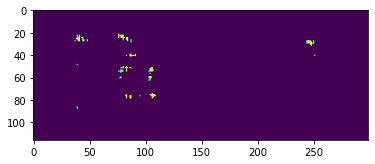

In [6]:
plt.imshow(cm)

In [2]:
runs = sorted(glob.glob("../../traj_save/*//*.pdb"))

In [9]:
df = []
cutoff = 10

for run in tqdm(runs[:]):
    pdb_file = run
    dcd_file = run.replace("pdb", "dcd")

    run_base = os.path.basename(run)[:-4]
    if run.split('/')[-2] == 'Nsp10_Nsp16': 
        if run_base.endswith('_0'): 
            run_base += '_000'
        else: 
            print(f'Skipped {run_base}')
            continue
    elif run.split('/')[-2].endswith('mono'): 
        continue

    mda_traj = mda.Universe(pdb_file, dcd_file)

    nsp16 = mda_traj.select_atoms("segid A")
    nsp10 = mda_traj.select_atoms("segid B")
#     no_sol = mda_traj.select_atoms("protein")
#     cm_list = []
    
    nsp16_ca = nsp16.select_atoms('name CA') 
    nsp10_ca = nsp10.select_atoms('name CA')
#     protein_ca = mda_traj.select_atoms('protein and name CA')
    for ts in mda_traj.trajectory[:]:
        cm  = (distances.distance_array(
            nsp10_ca.positions, nsp16_ca.positions, 
            box = ts.dimensions) < cutoff) * 1
        df.append({
            'sys_name': run_base,
            'frame': ts.frame,
            'n_contacts': np.sum(cm==1)})

  1%|          | 1/107 [00:05<09:29,  5.37s/it]

Skipped comp_1
Skipped comp_2


  4%|▎         | 4/107 [00:11<04:43,  2.75s/it]

Skipped comp_sah_1
Skipped comp_sah_2


  7%|▋         | 7/107 [00:18<04:03,  2.44s/it]

Skipped comp_sam_1
Skipped comp_sam_2


  9%|▉         | 10/107 [00:24<03:44,  2.31s/it]

Skipped comp_sfg_1
Skipped comp_sfg_2


100%|██████████| 107/107 [03:58<00:00,  2.23s/it]


In [11]:
df = pd.DataFrame(df)
df.head()

,sys_name,frame,n_contacts
0,comp_0_000,0,143
1,comp_0_000,1,144
2,comp_0_000,2,156
3,comp_0_000,3,149
4,comp_0_000,4,157


In [12]:
df

,sys_name,frame,n_contacts
0,comp_0_000,0,143
1,comp_0_000,1,144
2,comp_0_000,2,156
3,comp_0_000,3,149
4,comp_0_000,4,157
...,...,...,...
359995,comp_sfg_100,3995,63
359996,comp_sfg_100,3996,60
359997,comp_sfg_100,3997,64
359998,comp_sfg_100,3998,71


In [14]:
df.to_pickle('n_contacts_nsp10-16.pkl')